<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/HUPV/notebooks/cv10_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 10 - VAE

In this lab, we will review how VAE (variational autoencoder) works and then implement it.

## VAE

VEA works on the encoder and decoder principle. We encode the original image, or some other type of input, to the so-called latent space. This allows us to create a reduction of multidimensional data to a smaller dimension. The decoder can then take these vectors at the input and generate the original image. This can be used, for example, to generate images from the dataset distribution.

We construct the encoder as a neural network that returns the parameters of the $q_\theta (z | x)$ distribution. We can select a sample $z$ from this distribution. We will model this distribution as a normal distribution, and $\theta$ will thus represent the parameters $\mu$ and $\sigma$. That is, the average and the standard deviation.

The decoder is then a network that accepts the vector $z$ as an input and generates the distribution $q_\phi (x | z)$ as an output. We then train this distribution using the so-called maximum likelihood against the training data. That is, for the $i$-th example from the training set. $$C = - \mathbb{E}_{z \sim q_\theta(z|x_i)} log(p_\phi (x_i | z))$$

Practically, the maximization of the log-likelihood is equivalent to the minimization of the cross-entropy, or another metric according to what we assume about the $p_\phi$ distribution.

However, such optimization is not enough. We still need to ensure that the distribution in the latent space is meaningful. We will ensure this by adding a so-called regularization term: Kullback-Leibler divergence. This metric allows us to calculate how similar two different distributions are. Our goal will be for the distribution $q_\theta$ to be as close as possible to the normal distribution $p(z)$. You can find the theoretical justification [here](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/), or [here](https://arxiv.org/pdf/1907.08956.pdf ).


$$ C = - \mathbb{E}_{\vec{z} \sim q_\theta(z|\vec{x}_i)} log(p_\phi (\vec{x}_i | \vec{z })) + D_{KL}(q_\theta(\vec{z}|\vec{x}_i) ~||~ p(\vec{z}))$$

$$ D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \mathbb{E}\left[log(q_\theta (\vec{z}|\vec{x})) - log(p(\vec{z}))\right].$$

We consider [normal distributions](https://en.wikipedia.org/wiki/Multivariate_normal_distribution):

$$q_\theta(\vec{z}|\vec{x}) = N(\vec{\mu}, \Sigma),~p(\vec{z}) = N(\vec{0}, \mathbb{I}),$$ $$\Sigma = diag(\sigma_1^2, \sigma_2^2, ..., \sigma_k^2)$$

$$N(\vec{\mu},\Sigma) = \frac{e^{-\frac{1}{2}(\vec{x} - \vec\mu)^T\Sigma^{-1 }(\vec{x} - \vec\mu)}}{\sqrt{2 \pi |\Sigma|}}$$

For KL divergence of normal distributions [we can derive](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence):


$$D_{KL}(N(\vec\mu_0, \Sigma_0) || N(\vec\mu_1, \Sigma_1)) = \frac{1}{2} \left( tr(\Sigma_1^{-1 } \Sigma_0) + (\vec\mu_1 - \vec\mu_0)^T \Sigma_1^{-1}(\vec\mu_1-\vec\mu_0) - k + ln \frac{|\Sigma_1|}{| \Sigma_0|}\right)$$

So:

$$D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \frac{1}{2}\left( \sum_ {i=1}^k \sigma_i + \sum_{i=1}^k \mu_i^2 - k + log\prod_{i=1}^k \frac{1}{\sigma_i^2} \right) $$

$$D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \frac{1}{2}\sum_{i= 1}^k \left(\sigma_i^2 + \mu_i^2 - 1 - log(\sigma_i^2) \right)$$

For numerical reasons, it is better to work directly with $log(\sigma_i^2)$ instead of $\sigma_i^2$ in the network. If we define:

$$\lambda_i = log(\sigma_i^2)$$

then finally:

$$D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \frac{1}{2}\sum_{i= 1}^k \left(e^{\lambda_i} + \mu_i^2 - 1 - \lambda_i \right)$$

## So how will it all work?

Both $\vec\mu$ and $\vec\lambda$ are calculated based on the $\vec{x}_i$ elements in the minibatch. That is the encoder (neural network) takes $\vec{x}_i$ at the input and calculates $\vec{\mu}$ and $\vec\lambda$ from it. Based on this, a sample from the $N(\vec{\mu}, \Sigma)$ distribution is selected as $\vec{z}$. This is then inserted into the encoder (neural network) and we get the result $\vec{y}$. We then train the network on a minibatch of size $M$ using loss, e.g. using cross-entropy:

$$ C = \frac{1}{M} \sum_{i = 1}^M CE\left(\vec{y}(\vec{z} \sim N[\vec{\mu}(\vec{ x}_i), \Sigma(\vec{x}_i)]), \vec{x}_i \right) + D_{KL}(\vec{\mu}(\vec{x}_i), \Sigma (\vec{x}_i)) $$

The last thing we have to solve is how we will select the samples $\vec{z}$ from the distribution $N(\vec{\mu}(\vec{x}_i), \Sigma(\vec{x}_i))$ so , so that the gradients are also propagated to the decoder. Fortunately, this can be done by sampling from a common normal distribution:

$$ z_j = \mu_j + \sigma_j \cdot N(0,1) = \mu_j + e^{\frac{\lambda_j}{2}} \cdot N(0,1)$$

## VAE diagram

Now you will implement the network according to this diagram:

![Alt text](https://raw.githubusercontent.com/kocurvik/edu/master/HUPV/supplementary/ntb_images/VAE_MNIST_small.png)

We basically have three models that share some layers. In the end, of course, you will only need to train the VAE model, and you can use the other two later for inference.

We will first download the MNIST dataset.

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
import numpy as np
x = np.array(mnist.data.astype('float32')/255)
labels = np.array(mnist.target.astype('int64'))

x_train = x[:50000]
labels_train = labels[:50000]
x_val = x[50000:60000]
labels_val = labels[50000:60000]
x_test = x[60000:]
labels_test = labels[60000:]

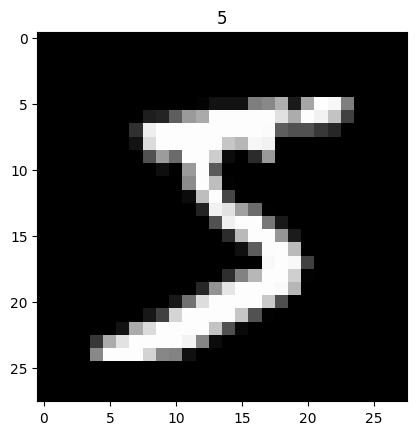

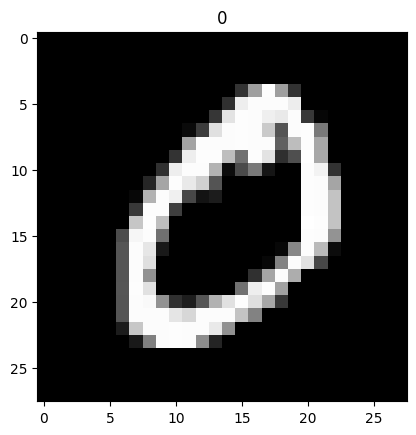

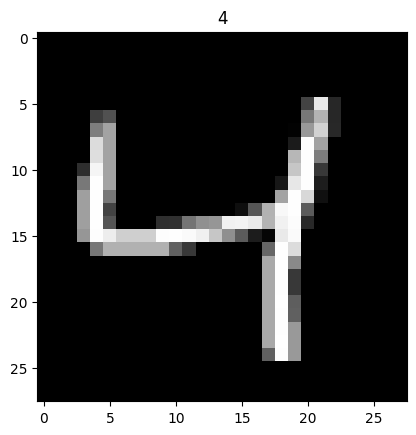

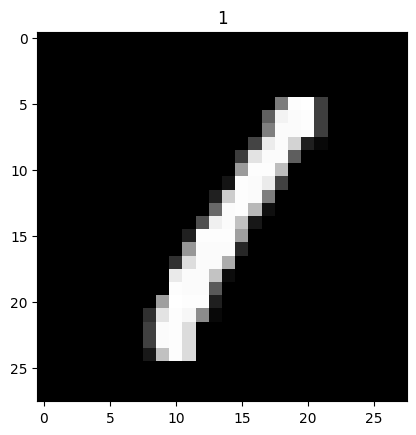

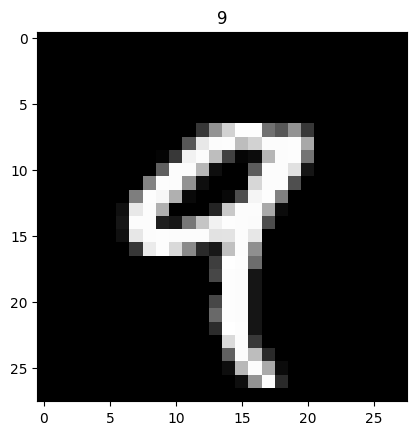

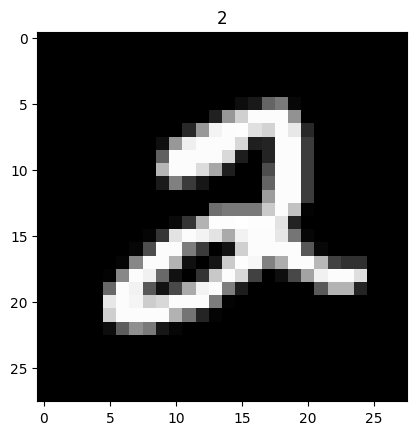

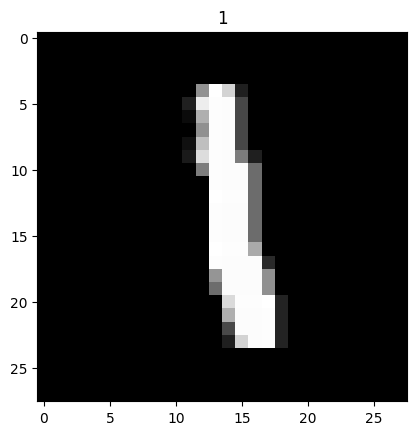

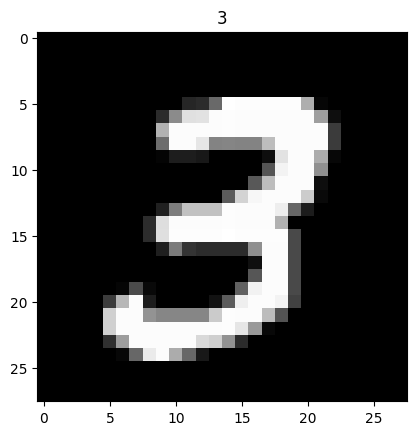

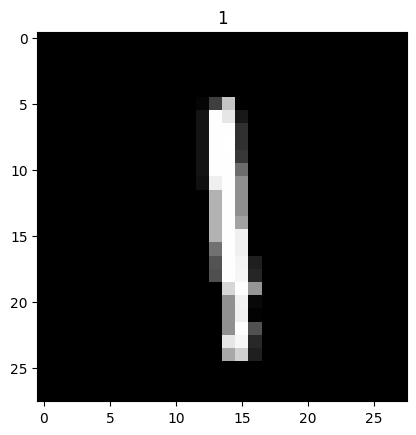

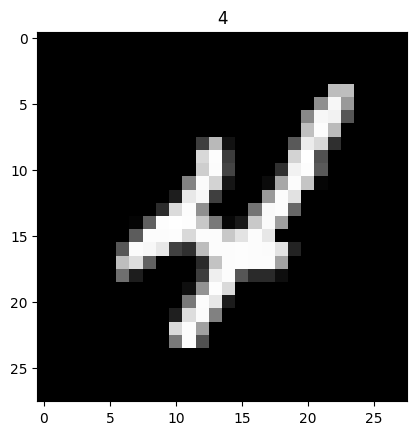

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

for i in range(10):
  plt.imshow(np.reshape(x[i, :],(28,28)), cmap='gray')
  plt.title(labels[i])
  plt.show()

## Exercise - Our VAE model

We will implement our model according to the following diagram:

![Alt text](https://raw.githubusercontent.com/kocurvik/edu/master/HUPV/supplementary/ntb_images/VAE_MNIST_small.png)

The model will have the following methods:
* Constructor
* `encode'
* `sample_z`
* `encode_before`
* `decode`
* `compute_loss`

In the constructor, we specify `n_hidden` and `n_z` and initialize the individual layers.


We will implement the `encode` method, which will always have an input tensor of size $n \times 784$. At the output, it returns the tensors $\lambda$ and $\mu$ both of size $n \times n_z$. Use the diagram to implement the appropriate operations.

Next, we will implement the `sample_z` method, which will have $\lambda$ and $\mu$ tensors as input, which will determine the parameters of the distribution, and the individual elements of $z$ will then be obtained from the formula:

$$ z_j = \mu_j + \sigma_j \cdot N(0,1) = \mu_j + e^{\frac{\lambda_j}{2}} \cdot N(0,1),$$

where $N(0, 1)$ will be a random number from a normal distribution. The output will then be the tensor $z$ with size $n \times n_z$. Remember that if you generate a random tensor you must then send it to the correct device for it to work.

There is also a prepared `encode_predict` method in the code, which just combines the `encode` and `sample_z` methods. This method basically implements the green part of the calculation from the diagram.

Next, we implement the `decode` method, which receives a $z$ tensor of size $n \times n_z$ as an input and returns an image. This method implements the blue part of the calculation in the diagram.

Finally, we implement the `compute_loss` method, which receives an input tensor of size $n \times 784$ with an MNIST image endcoded, sample_z and decode and returns a price function from the intermediate values:

$$ C = - \mathbb{E}_{\vec{z} \sim q_\theta(z|\vec{x}_i)} log(p_\phi (\vec{x}_i | \vec{z })) + D_{KL}(q_\theta(\vec{z}|\vec{x}_i) ~||~ p(\vec{z})),$$

while the first term is actually the binary crossentropy between the output from the encoder and the input to the decoder, and the second term has the form

$$D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \frac{1}{2}\sum_{i= 1}^k \left(e^{\lambda_i} + \mu_i^2 - 1 - \lambda_i \right)$$

*Note:* You will use `torch.nn.BCELoss` when calculating loss. Use `reduction='sum'' in the constructor to avoid [this problem.](https://stackoverflow.com/questions/50607516/variational-autoencoder-gives-same-output-image-for-every-input -mnist-image-when)

*Note:* Instead of the output image we could also output two distribution parameters for each pixel and then sample from the distributions to obtain the image as is usually done in VAE implementations. However, this makes the network more comlicated so we will simply output the final pixel values directly.

In [ ]:
import torch
from torch.nn import Linear
from torch.nn.functional import relu

class VAE(torch.nn.Module):
  def __init__(self, n_z, n_hidden):
    super(VAE, self).__init__()
    # implement

  def encode(self, x):
    # implement

  def sample_z(self, lam, mu):
    # implement

  def encode_pred(self, x):
    lam, mu = self.encode(x)
    z = self.sample_z(lam, mu)
    return z

  def decode(self, z):
    # implement

  def compute_loss(self, x):
    # implement

The following code should be able to verify that your code at least approximately does what it is supposed to do.

In [ ]:
vae = VAE(7, 64)

r_inp = torch.rand(16, 784)
lam, mu = vae.encode(r_inp)
print("Chceme size 16, 7 pre lam, mu, z")
print(lam.size(), mu.size())
z = vae.sample_z(lam, mu)
print(z.size())

out = vae.decode(z)
print("Chceme size 16, 784")
print(out.size())

print("Chceme size 16, 7 pre z")
z_direct = vae.encode_pred(r_inp)
print(z_direct.size())


print("Loss by mala byť skalárna")
loss = vae.compute_loss(r_inp)
print(loss)

Chceme size 16, 7 pre lam, mu, z
torch.Size([16, 7]) torch.Size([16, 7])
torch.Size([16, 7])
Chceme size 16, 784
torch.Size([16, 784])
Chceme size 16, 7 pre z
torch.Size([16, 7])
Loss by mala byť skalárna
tensor(8818.9580, grad_fn=<AddBackward0>)


We can train the network.

In [ ]:
batch_size = 32

dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(x_train))
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)

vae = VAE(2, 64).cuda()

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

for e in range(10):
  running_loss = 0
  train_losses = []
  for i, sample in enumerate(dataloader_train):
    optimizer.zero_grad()

    loss = vae.compute_loss(sample[0].cuda())

    loss.backward()

    optimizer.step()

    running_loss = 0.9 * running_loss + 0.1 * loss.item()
    train_losses.append(loss.item())

    if i % 100 == 99:
      print("At step {} running loss: {}".format(i + 1, running_loss))

  print('*' * 20)

  print("After epoch {} mean train loss: {}".format(e, np.mean(train_losses)))

At step 100 running loss: 15597.79039039308
At step 200 running loss: 9402.459179030682
At step 300 running loss: 7662.614036009587
At step 400 running loss: 7384.291877978356
At step 500 running loss: 6940.6998274122525
At step 600 running loss: 6725.52133973278
At step 700 running loss: 7027.494788657744
At step 800 running loss: 6951.0948013714515
At step 900 running loss: 6959.592360389197
At step 1000 running loss: 6601.762446528385
At step 1100 running loss: 6613.22010661877
At step 1200 running loss: 6562.293672089098
At step 1300 running loss: 6624.324200113832
At step 1400 running loss: 6374.9458241846405
At step 1500 running loss: 6449.913756067237
********************
After epoch 0 mean train loss: 7825.514340411069
At step 100 running loss: 6178.322860640799
At step 200 running loss: 6284.290646221254
At step 300 running loss: 6285.6053721406115
At step 400 running loss: 6402.2899625818245
At step 500 running loss: 6142.361712353198
At step 600 running loss: 6023.4883588129

## Image Generation

tensor([[ 0.5248, -0.5718]])


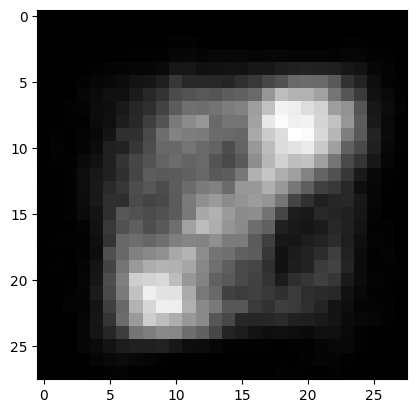

tensor([[-1.3690,  0.6694]])


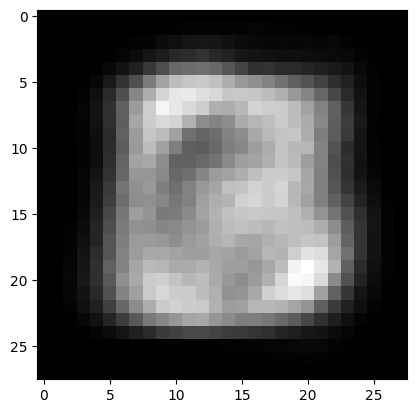

tensor([[ 0.9325, -1.5767]])


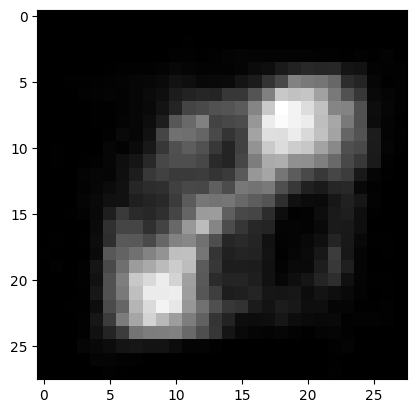

tensor([[-0.5847, -0.4718]])


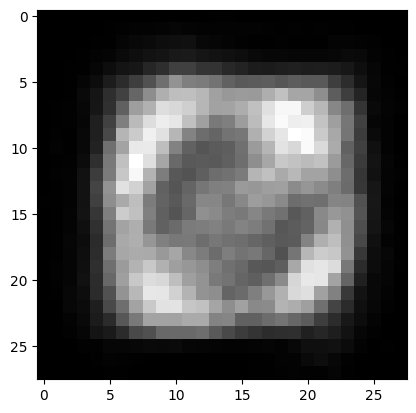

tensor([[1.4005, 0.4958]])


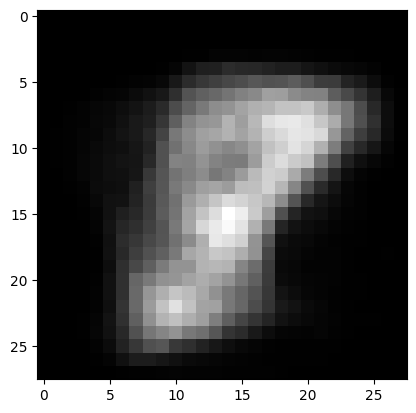

tensor([[-0.0227,  0.2650]])


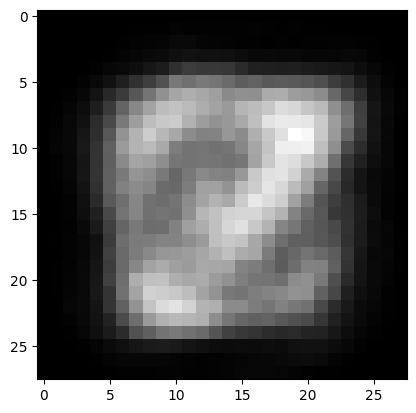

tensor([[-1.0467, -0.3548]])


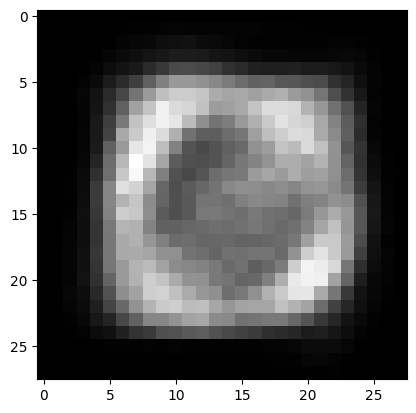

tensor([[ 1.5161, -0.1265]])


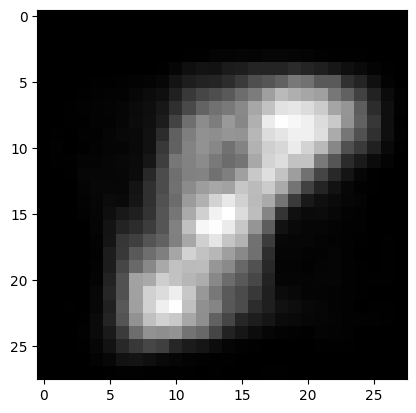

tensor([[1.1492, 0.1674]])


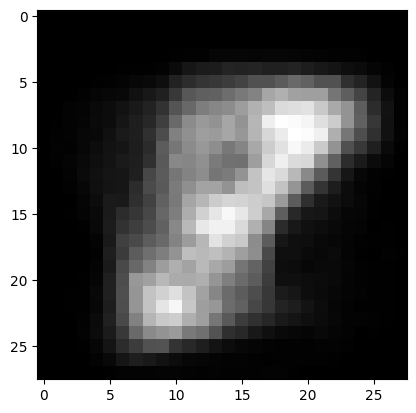

tensor([[-0.2916,  0.7423]])


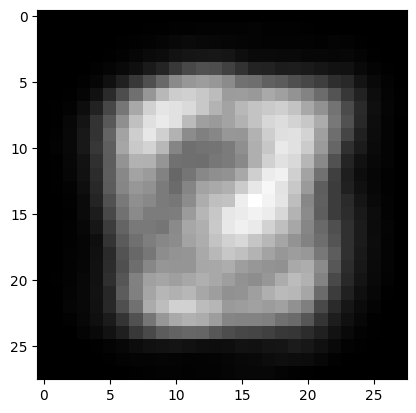

In [ ]:
with torch.no_grad():
  for i in range(10):
    z_example = torch.randn(1,2)
    print(z_example)
    prediction = vae.decode(z_example.cuda())
    plt.imshow(np.reshape(prediction[0].detach().cpu().numpy(), [28, 28]), cmap='gray')
    plt.show()

## Distribution in latent space

We can also visualize what the latent space looks like if we plot where the latent vectors for different numbers are located.

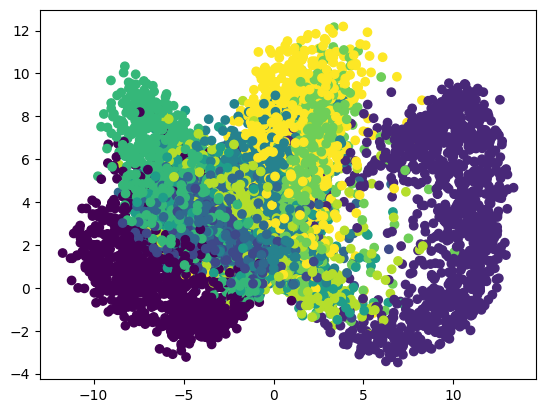

In [ ]:
for i in range(10000//32):
  prediction = vae.encode_pred(torch.from_numpy(x_test[i*32:(i+1)*32, :]).cuda())
  prediction = prediction.detach().cpu().numpy()
  if i == 0:
    z_list = prediction
  else:
    z_list = np.row_stack([z_list, prediction])

plt.scatter(z_list[:, 0], z_list[:, 1], c = labels_test[:len(z_list)])
plt.show()

We can also try this on the training set.

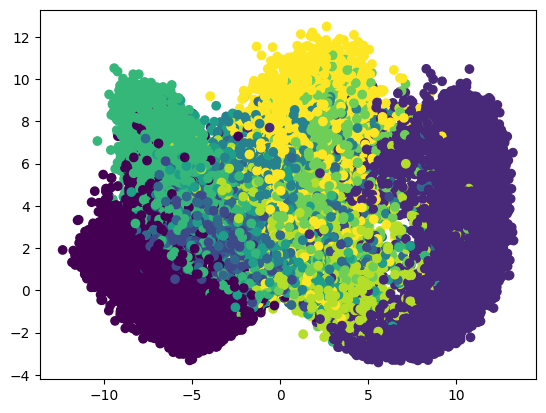

In [ ]:
for i in range(50000//32):
  prediction = vae.encode_pred(torch.from_numpy(x_train[i*32:(i+1)*32, :]).cuda())
  prediction = prediction.detach().cpu().numpy()
  if i == 0:
    z_list = prediction
  else:
    z_list = np.row_stack([z_list, prediction])

plt.scatter(z_list[:, 0], z_list[:, 1], c = labels_train[:len(z_list)])
plt.show()

## Visualization of images in latent space

We can also view the images generated for each z from the latent space by gradually changing the z values.

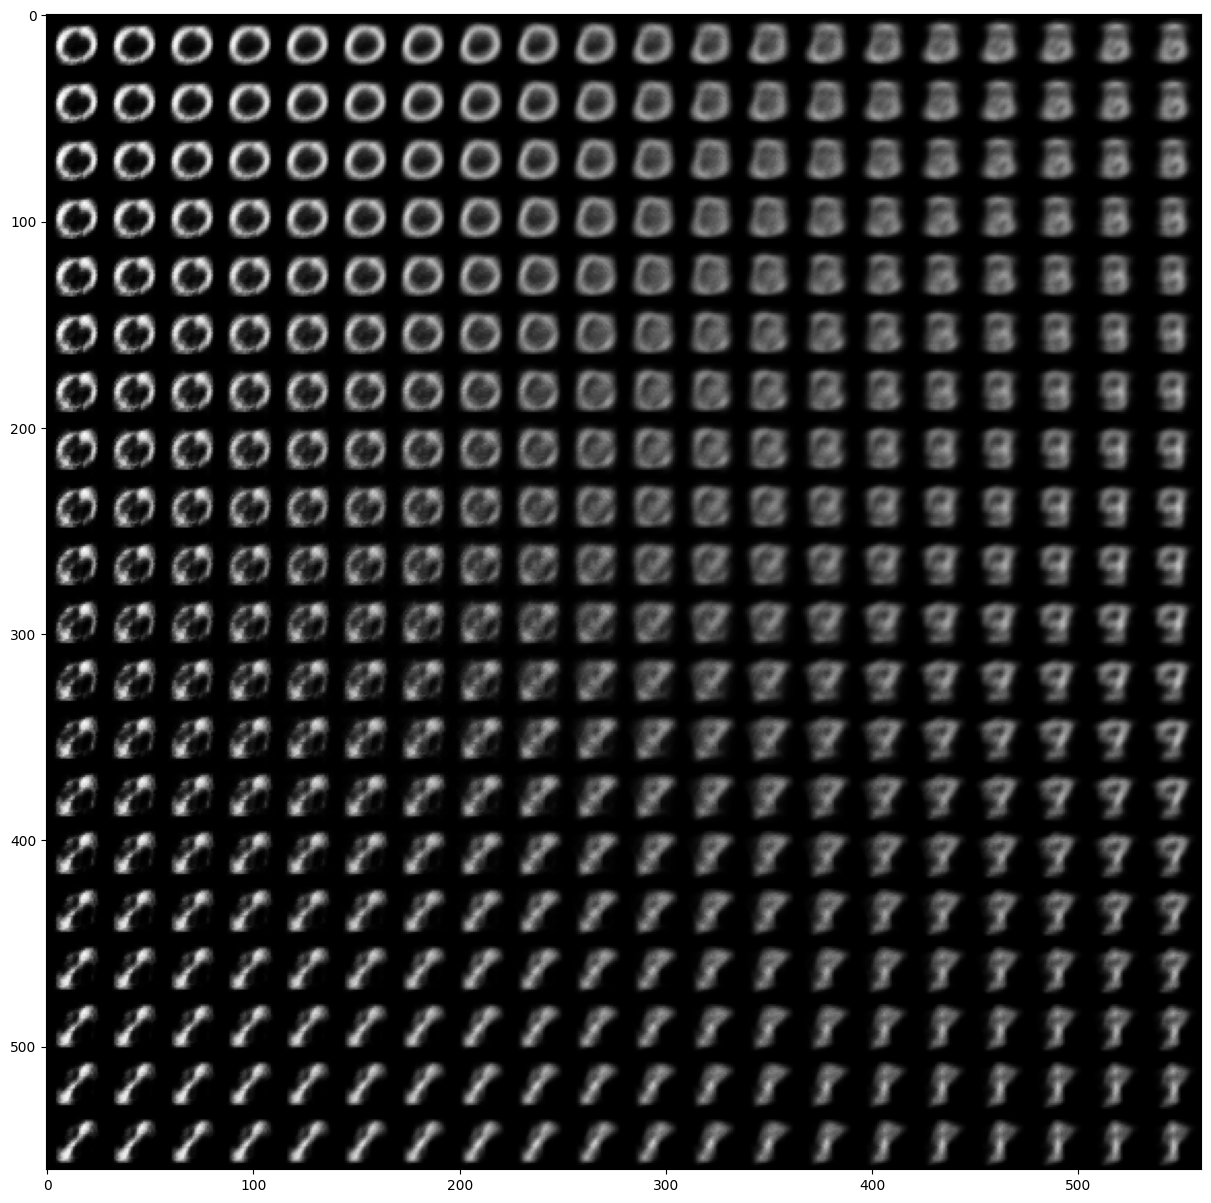

In [ ]:
n_images = 20

final_image = np.zeros([28*n_images,28*n_images])

for i, z1 in enumerate(np.linspace(-3, 3, n_images)):
  for j, z2 in enumerate(np.linspace(-3, 3, n_images)):
    prediction = vae.decode(torch.tensor([[z1, z2]]).float().cuda())
    final_image[i*28:(i+1)*28, j*28:(j+1)*28] = np.reshape(prediction[0].detach().cpu().numpy(), [28, 28])

plt.figure(figsize = (15, 15))
plt.imshow(final_image, cmap='gray')
plt.show()

## 3D visualization

We can also view similar things in 3D. First, we train the model and then we make visualizations.

This code was created by Filip Pavlove as part of the DÚ replacement:
https://github.com/kocurvik/edu/blob/master/HUPV/notebooks/pytorch/cv10-solution.ipynb



In [ ]:
batch_size = 32

dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(x_train))
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)

vae3 = VAE(3, 64).cuda()

optimizer = torch.optim.Adam(vae3.parameters(), lr=1e-4)

for e in range(10):
  running_loss = 0
  train_losses = []
  for i, sample in enumerate(dataloader_train):
    optimizer.zero_grad()

    loss = vae3.compute_loss(sample[0].cuda())

    loss.backward()

    optimizer.step()

    running_loss = 0.9 * running_loss + 0.1 * loss.item()
    train_losses.append(loss.item())

    if i % 100 == 99:
      print("At step {} running loss: {}".format(i + 1, running_loss))

  print('*' * 20)

  print("After epoch {} mean train loss: {}".format(e, np.mean(train_losses)))

At step 100 running loss: 14960.284543163938
At step 200 running loss: 9081.895514997841
At step 300 running loss: 7631.990009053575
At step 400 running loss: 7396.119327740905
At step 500 running loss: 6963.637328892764
At step 600 running loss: 6745.678954408832
At step 700 running loss: 7027.087131850421
At step 800 running loss: 6944.603310616518
At step 900 running loss: 6921.39894537978
At step 1000 running loss: 6549.2402835172015
At step 1100 running loss: 6551.495008059244
At step 1200 running loss: 6479.101155722522
At step 1300 running loss: 6589.85909242817
At step 1400 running loss: 6337.528405713435
At step 1500 running loss: 6413.827389135044
********************
After epoch 0 mean train loss: 7745.776532447117
At step 100 running loss: 6166.7958241277875
At step 200 running loss: 6285.165205711216
At step 300 running loss: 6267.251918443317
At step 400 running loss: 6336.577441852409
At step 500 running loss: 6060.018270766518
At step 600 running loss: 5944.727665015943

In [ ]:
for i in range(10000//32):
  prediction = vae3.encode_pred(torch.from_numpy(x_test[i*32:(i+1)*32, :]).cuda())
  prediction = prediction.detach().cpu().numpy()
  if i == 0:
    z_list = prediction
  else:
    z_list = np.row_stack([z_list, prediction])


import plotly.graph_objects as go

x, y, z = z_list[:, 0], z_list[:, 1], z_list[:, 2]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(
        size=1,
        color=labels_test[:len(z_list)].flatten(),
        colorscale='Viridis',
        opacity=0.8
    ))])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

We can use sliders to see how the generated numbers change.

In [ ]:
%%capture
%matplotlib inline
from ipywidgets import interact, widgets
from IPython.display import display


def f(z1, z2, z3):
    prediction = vae3.decode(torch.tensor([[z1/100, z2/100, z3/100]]).float().cuda())
    ax.imshow(np.reshape(prediction[0].detach().cpu().numpy(), [28, 28]), cmap="gray")
    fig.canvas.draw()
    display(fig)

fig = plt.figure(figsize=(6, 4))
ax  = fig.add_subplot(111)

prediction = vae3.decode(torch.tensor([[0, 0, 0]]).float().cuda())
ax.imshow(np.reshape(prediction[0].detach().cpu().numpy(), [28, 28]), cmap="gray")

In [ ]:
interact(f, z1=widgets.IntSlider(min=-600,max=600,step=2,value=0),
            z2=widgets.IntSlider(min=-600,max=600,step=2,value=0),
            z3=widgets.IntSlider(min=-600,max=600,step=2,value=0))

interactive(children=(IntSlider(value=0, description='z1', max=600, min=-600, step=2), IntSlider(value=0, desc…

<function __main__.f(z1, z2, z3)>